# <center>动量因子</center>

# 动量策略的一点历史

## 三大互补选股维度

1、`Momentum:`**当价格沿着过去的轨迹继续运动时**（即价格上涨的还会涨，价格下跌的还会跌），我们能够获得收益；  

2、`Value:`**当价格恢复到之前的某种均衡状态时**（即价格围绕基本面价值往复运动），我们能够获得收益；  

3、`Carry:`**当价格不发生变化时**，我们能够获得收益。股东分红收益。

注：假如我们买入一支股票并一直持有，如果股票价格不变，那么我们获得的收益就是该股票的分红。股息率（diviedend yield）就是Carry收益率。

## 动量策略的发展  

+ `1967年`，Robert Levy在*Journal of Finance* 发表了Relative Strength as a Criterion for Investment Selection 的文章（当年动量一词还未被造出）；


+ `1970s开始`，有效市场假说（EMH）被提出并成为主流；**动量现象的研究被极大地抑制**。随着人们对市场理解的加深以及价值投资的巨大成功，EMH不再权威，但动量任然被认为是‘一种黑色艺术、一种巫术魔力’；


+ `1993年`，Jegadeesh和Titman在*Journal of Finance* 发表了一篇里程碑式的文章，题为Return to Buying Winners and Selling Losers:Implications for Stock Market Efficiency；


+ `2008年`，EMH之父Eugene Fama在美国金融协会的采访中承认了动量的存在；


+ `2013年`，Asness等人在*Journal of Finance* 发表了影响深远的Value and Momentum Everywhere。  

## Momentum和Value无处不在

**核心论文**

+ Asness, C. S., T. J. Moskowitz, and L. H. Pedersen (2013). Value and Momentum Everywhere.Journal of Finance,Vol.68(3),929–985.
+ Gray,W.R.and J.R.Vogel (2016).Quantitative Momentum,a Practitioner’s Guide to Building a Momentum-Based Stock Selection System.John Wiley & Sons,Inc.,Hoboken,New Jersey.

# 基础版动量策略

## 策略出发点

1、`在中国股市中，反转强于动量`，且海外流行的动量选股方法（即使用t-12月到t-1月之间的收益率选股）并不好使。

2、在构造动量因子时，应该`注意其在市值因子上的暴露`。  

## 构造动量因子 

使用过去60个交易日风险调整后的涨跌幅作为动量因子（它和市值因子的相关性仅为0.085），其计算公式如下所示：  

### $$r_{60}-3000*\sigma ^{2}$$

其中$r_{60}$为60日涨跌幅，即60个交易日内的收益率;$\sigma$为60个交易日内收益率的标准差，代表风险。

## 策略思想  

1、回测期：2010年1月1日至2020年12月31日；  

2、调仓日：按月调仓，每月末按收盘价买卖股票；  

3、股票池：中证500成分股；剔除ST股票；剔除由于停牌等原因而无法买卖的股票；  

4、交易模型：

+ 每月末更新动量指标并重新对股票排名，新股理想仓位为1%，等权配置；


+ 将中证500成分股按因子排名分为5组，由于因子值越大越好，按由小到大排名，组别越大的组合越好，即G5组优于G1组；


**备注：**由于按日调仓需提取的日度数据量较为庞大，此处且先采用按月调仓的策略来传递高质量动量选股思想和呈现选股效果。

In [1]:
import numpy as np
import pandas as pd
import empyrical as ep

import alphalens as al
import alphalens.performance as perf
from alphalens import plotting

from jqdata import *
from jqfactor import (Factor,calc_factors)

from typing import (Tuple,List)
from functools import reduce
from tqdm import tqdm_notebook
from dateutil.parser import parse

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdate

mpl.rcParams['font.family']='serif' # pd.plot中文
# 用来正常显示负号
mpl.rcParams['axes.unicode_minus'] = False
# 图表主题
plt.style.use('seaborn')

In [21]:
# 工具函数
def tdaysoffset(end_date: str, count: int) -> datetime.date:
    '''
    end_date:为基准日期
    count:为正则后推，负为前推
    -----------
    return datetime.date
    '''

    trade_date = get_trade_days(end_date=end_date, count=1)[0]

    if count > 0:
        # 将end_date转为交易日

        trade_cal = get_all_trade_days().tolist()

        trade_idx = trade_cal.index(trade_date)

        return trade_cal[trade_idx + count]

    elif count < 0:

        return get_trade_days(end_date=trade_date, count=abs(count))[0]

    else:

        raise ValueError('别闹！')


def Strategy_performance(return_df: pd.DataFrame, periods='monthly') -> pd.DataFrame:
    '''计算风险指标 默认为月度:月度调仓'''

    ser: pd.DataFrame = pd.DataFrame()
    ser['年化收益率'] = ep.annual_return(return_df, period=periods)
    ser['波动率'] = return_df.apply(lambda x: ep.annual_volatility(x,period=periods))
    ser['夏普'] = return_df.apply(ep.sharpe_ratio, period=periods)
    ser['最大回撤'] = return_df.apply(lambda x: ep.max_drawdown(x))
    
    if 'benchmark' in return_df.columns:

        select_col = [col for col in return_df.columns if col != 'benchmark']

        ser['IR'] = return_df[select_col].apply(
            lambda x: information_ratio(x, return_df['benchmark']))
        ser['Alpha'] = return_df[select_col].apply(
            lambda x: ep.alpha(x, return_df['benchmark'], period=periods))

    return ser.T


def information_ratio(returns, factor_returns):
    """
    Determines the Information ratio of a strategy.

    Parameters
    ----------
    returns : :py:class:`pandas.Series` or pd.DataFrame
        Daily returns of the strategy, noncumulative.
        See full explanation in :func:`~empyrical.stats.cum_returns`.
    factor_returns: :class:`float` / :py:class:`pandas.Series`
        Benchmark return to compare returns against.

    Returns
    -------
    :class:`float`
        The information ratio.

    Note
    -----
    See https://en.wikipedia.org/wiki/information_ratio for more details.

    """
    if len(returns) < 2:
        return np.nan

    active_return = _adjust_returns(returns, factor_returns)
    tracking_error = np.std(active_return, ddof=1)
    if np.isnan(tracking_error):
        return 0.0
    if tracking_error == 0:
        return np.nan
    return np.mean(active_return) / tracking_error


def _adjust_returns(returns, adjustment_factor):
    """
    Returns a new :py:class:`pandas.Series` adjusted by adjustment_factor.
    Optimizes for the case of adjustment_factor being 0.

    Parameters
    ----------
    returns : :py:class:`pandas.Series`
    adjustment_factor : :py:class:`pandas.Series` / :class:`float`

    Returns
    -------
    :py:class:`pandas.Series`
    """
    if isinstance(adjustment_factor, (float, int)) and adjustment_factor == 0:
        return returns.copy()
    return returns - adjustment_factor

def get_group(df:pd.DataFrame,target_factor:str,num_group:int=5)->pd.DataFrame:
    
    '''
    分组
    ----
        target_factor:目标列
        num_group:默认分5组
    '''
    df = df.copy()
    label = ['G%s' % i for i in range(1, num_group+1)]
    df['group'] = df.groupby(level='date')[target_factor].transform(
    lambda x: pd.qcut(x, 5, labels=label))
    
    return df

def get_algorithm_return(factor_df:pd.DataFrame)->pd.DataFrame:
    
    '''
    获取分组收益率
    ---------
        传入df数据结构
           ----------------------------------------------
                      |       |factor|group| next_return|
           ----------------------------------------------
               date   | asset |      |     |            |
           ----------------------------------------------
                      | AAPL  |  0.5 |  G1 |   0.23     |
                      -----------------------------------
                      | BA    | -1.1 |  G2 |   -0.7     |
                      -----------------------------------
           2014-01-01 | CMG   |  1.7 |  G2 |   0.023    |
                      -----------------------------------
                      | DAL   | -0.1 |  G3 |   -0.03    |
                      -----------------------------------
                      | LULU  |  2.7 |  G1 |   -0.21    |
                      -----------------------------------
    '''
    
    returns = pd.pivot_table(factor_df.reset_index(
    ), index='date', columns='group', values='next_ret')
    returns.columns = [str(i) for i in returns.columns]

    returns.index = pd.to_datetime(returns.index)
    
    return returns


def plot_nav(nav: pd.DataFrame, title: str):
    '''
    画图
    ---------
        nav数据结构
        -------------------------------------
        |  date    | 1  | 2  | 3  | 4  | 5  |
        -------------------------------------
        |2020-01-01|0.01|0.02|0.14|-0.2|0.08|
        -------------------------------------
        |2020-01-02|0.11|-0.2|-0.1|0.33|0.10|
        -------------------------------------
    '''

    plt.rcParams['font.family'] = 'serif'
    fig, ax = plt.subplots(figsize=(18, 6))
    # 设置标题
    plt.title(title)
    # 1,5组设置不同的颜色和线型方便查看单调性
    ax.plot(nav['G1'], color='Navy')
    ax.plot(nav['G2'], color='LightGrey', ls='-.')
    ax.plot(nav['G3'], color='DimGray', ls='-.')
    ax.plot(nav['G4'], color='DarkKhaki', ls='-.')
    ax.plot(nav['G5'], color='LightSteelBlue')
        
    ax.axhline(1, color='black', lw=0.5)
    # 多空单独反应
    #ax1 = ax.twinx()
    ax.plot(nav['excess_ret'], color='r', ls='--')
    if 'benchmark' in nav.columns:
        ax.plot(nav['benchmark'],color='black',ls='--')
    #ax1.grid(None)
    # 图例合并
    h1, l1 = ax.get_legend_handles_labels()
    #h2, l2 = ax1.get_legend_handles_labels()
    #l2 = [l2[0] + '(right)']
    #ax.legend(h1+h2, l1+l2)
    ax.legend(h1,l1)

### 提取调仓日期
先是提取2010年1月1日-2020年12月31日回测区间内的各个月末交易日期，再提取每月月末往前推60日的交易日期，以便后面计算回测区间内的各个月末交易日期对应的过去60日涨跌幅。

In [3]:
# 获取年末季末时点

def GetTradePeriod(start_date: str, end_date: str, freq: str = 'ME') -> list:
    '''
    start_date/end_date:str YYYY-MM-DD
    freq:M月，Q季,Y年 默认ME E代表期末 S代表期初
    ================
    return  list[datetime.date]
    '''
    days = pd.Index(pd.to_datetime(get_trade_days(start_date, end_date)))
    idx_df = days.to_frame()

    if freq[-1] == 'E':
        day_range = idx_df.resample(freq[0]).last()
    else:
        day_range = idx_df.resample(freq[0]).first()

    day_range = day_range[0].dt.date

    return day_range.dropna().values.tolist()

### 构建选股函数
先提取各调仓日的中证500成分股，再剔除ST和由于停牌等原因而无法买卖的股票，即保留中证500中非ST和处于交易状态的股票。

In [4]:
# 获取股票池
def get_stockpool(symbol: str, watch_date: str) -> list:
    '''获取股票池'''

    if symbol == 'A':
        stockList = get_index_stocks('000002.XSHG', date=watch_date) + get_index_stocks(
            '399107.XSHE', date=watch_date)
    else:
        stockList = get_index_stocks(symbol, date=watch_date)
    stockList = del_st_stock(stockList, watch_date)  # 过滤ST
    stockList = del_iponday(stockList, watch_date)  # 过滤上市不足60日
    stockList = del_paused(stockList, watch_date)  # 过滤20日未交易股票

    return stockList


def del_st_stock(securities: list, watch_date: str) -> list:
    '''过滤ST股票'''

    info_ser = get_extras('is_st', securities,
                          end_date=watch_date, df=True, count=1).iloc[0]

    return info_ser[info_ser == False].dropna().index.tolist()


def del_iponday(securities: list, watch_date: str, N: int = 60) -> list:
    '''返回上市大于N日的股票'''
    return list(filter(lambda x: (parse(watch_date).date() - get_security_info(x, date=watch_date).start_date).days > N, securities))


def del_paused(securities: list, watch_date: str, N: int = 21) -> list:
    '''返回N日内未停牌的股票'''
    pausd_df = get_price(securities, end_date=watch_date,
                         count=N, fields='paused', panel=False)
    cond = pausd_df.groupby('code')['paused'].sum()

    return cond[cond == 0].dropna().index.tolist()

### 构建动量因子

先提取出各调仓日满足选股条件的股票对应的**过去60日涨跌幅**，再提取各股票**过去60日的收益波动率**，最后利用前面的因子计算公式**计算动量因子**。

In [5]:
class momentum_factor(Factor):
    
    '''动量'''
    
    import warnings
    warnings.filterwarnings("ignore")
    
    name = 'momentum_factor'
    max_window = 62
    dependencies = ['close']
    
    def calc(self,data)->pd.Series:
        
        close_df = data['close'].iloc[:-1] # 不函watch日当日 
        pct_df = close_df.pct_change().iloc[1:] # 首日得到的是缺失值，需将其删除
        std_df = pct_df.std()
        ret = close_df.iloc[-1] / close_df.iloc[0] - 1 # r_60
        return ret - 3000 * std_df ** 2

In [6]:
def prepare_data(symbol: str, start: str, end: str, last_date: str, target_factor) -> pd.Series:
    '''
    symbol:股票池所属成份，A为全市场
    start,end:回测区间 频率为月度
    last_date:计算next_returns的最后一日的日期
    factor:构建的因子
    '''
    periods = GetTradePeriod(start, end, 'ME')
    periods = periods + [last_date]
    factor_dic = {}
    for tradeDate, nextDate in tqdm_notebook(zip(periods[:-1], periods[1:]), total=len(periods)-1, desc='因子计算'):

        stock_pool = get_stockpool(symbol, tradeDate.strftime('%Y-%m-%d'))
        factor = calc_factors(
            stock_pool, [target_factor()], start_date=tradeDate, end_date=tradeDate)
        factor = factor[target_factor.__name__].iloc[-1]  # 转为Series

        close = get_price(stock_pool, end_date=tradeDate, count=1,
                          fields='close', panel=False).set_index('code')
        next_close = get_price(stock_pool, end_date=nextDate,
                               count=1, fields='close', panel=False).set_index('code')

        next_returns = next_close['close'] / close['close'] - 1

        tmp = pd.concat((factor, next_returns), axis=1)
        tmp.columns = [target_factor.__name__, 'next_ret']
        factor_dic[tradeDate] = tmp

    factor_df = pd.concat(factor_dic)
    factor_df.index.names = ['date', 'code']
    return factor_df

In [7]:
start = '2010-01-01'
end = '2020-12-31'
last_date = '2021-01-27'

# 大约1:26min
momentum_df1 = prepare_data('000905.XSHG',start,end,last_date,momentum_factor)

### 按因子排名进行分组

由于动量因子越大越好，在对因子按升序排名并分组后，组号越大的组合表现越优，即G5>G4>G3>G2>G1。

### 进行分组回测  

1. 回测期：2010年1月1日至2020年12月31日；  

2. 调仓日：按月调仓，每月末按收盘价买卖股票；  

3. 股票池：中证500成分股；剔除ST股票；剔除由于停牌等原因而无法买卖的股票；  

4. 回测基准：中证500

5. 分组情况：共分为5组，表现优劣排名为G5>G4>G3>G2>G1；

6. 分组回测后得到的是各组与基准的净值，并绘制了净值曲线。

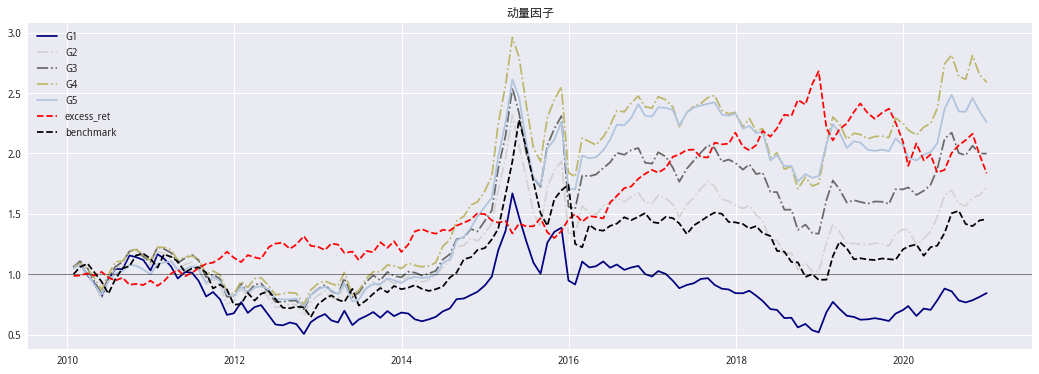

In [22]:
group_df1 = get_group(momentum_df1,'momentum_factor')
returns1 = get_algorithm_return(group_df1)

benchmark = get_price('000905.XSHG', start, end, fields='close')
benchmark = benchmark.reindex(returns1.index)
benchmark = benchmark['close'].pct_change().fillna(0)
returns1['benchmark'] = benchmark

returns1['excess_ret'] = returns1['G5'] - returns1['G1']
cum_df1 = np.exp(np.log1p(returns1).cumsum())

plot_nav(cum_df1,'动量因子')

从净值曲线来看，G4-G5组的表现要优于沪深300的表现，G1-G3组劣于沪深300；对于表现较为优异的G4，G5，净值曲线并不是很分散，交叉重叠的较多；G5组在前期表现不佳，但后期表现优异；虽然G5表现不是特别突出，但其收益要比其余两组稳定，这一结论从后面的策略表现分析中也能得到证实。

下图为动量因子月度IC值，可以看的动量因子大概率在0轴以上，因子与下期收益率正关

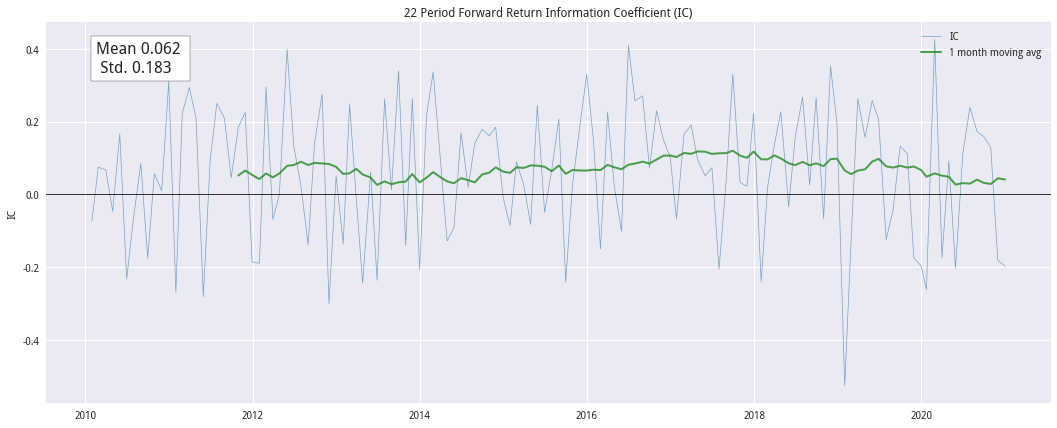

In [9]:
# 转为alphalens规定的格式
al_factor1 = momentum_df1.rename(
    columns={'momentum_factor': 'factor', 'next_ret': 22})

al_factor1 = al_factor1.dropna() # 缺失值较小，这里直接丢弃缺失值 
ic = perf.factor_information_coefficient(al_factor1)
plotting.plot_ic_ts(ic);

### 策略表现分析

通过计算各组别与基准的年化收益率、收益波动率、夏普比率、最大回撤、Alpha、IR等指标，来对比分析各组的收益表现。

各组收益表现与前面的净值曲线结果相对应。无论是从收益角度来看，还是从风险角度来看，G5的表现都是最好的，不仅能取得较高收益，而且风险也最小，收益最稳定，G5的sharpe也是最优的，能在承担风险的同时能带来最高的收益。

In [10]:
(Strategy_performance(returns1).style.format('{:.2%}')
                                     .set_caption('动量因子')
                                     .highlight_max(axis=1, color='#d65f5f')
                                     .highlight_min(axis=1, color='#5fba7d'))

,G1,G2,G3,G4,G5,benchmark,excess_ret
年化收益率,-1.54%,5.04%,6.49%,9.03%,7.69%,3.47%,5.67%
波动率,32.06%,29.18%,27.48%,26.41%,23.82%,26.32%,15.53%
夏普,10.93%,31.47%,36.78%,46.02%,43.05%,26.17%,43.46%
最大回撤,-68.94%,-56.01%,-47.49%,-42.34%,-34.88%,-58.18%,-31.52%
IR,-2.43%,1.77%,2.60%,4.42%,2.98%,nan%,-0.14%
Alpha,2.97%,8.45%,9.24%,11.13%,9.26%,nan%,6.29%


# 升级版动量策略

## 出处
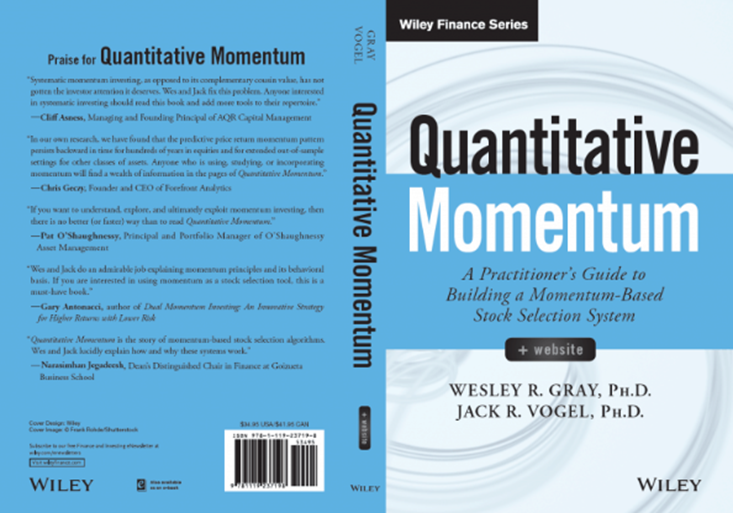

**中文版**
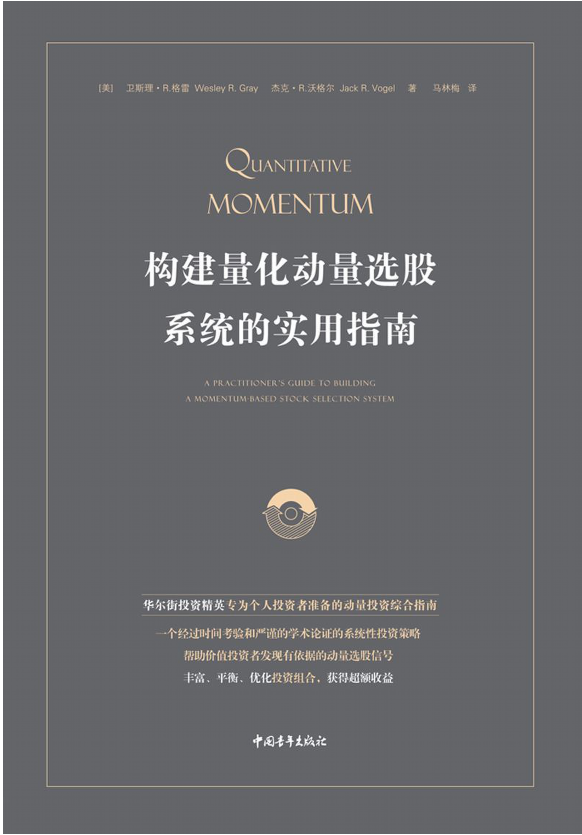
+ Gray,W.R.and J.R.Vogel (2016). Quantitative Momentum,a Practitioner’s Guide to Building a Momentum-Based Stock Selection System.John Wiley & Sons,Inc.,Hoboken,New Jersey.

## 动量积累的路径很重要
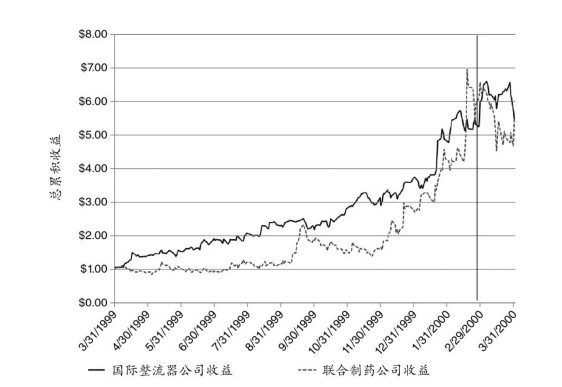

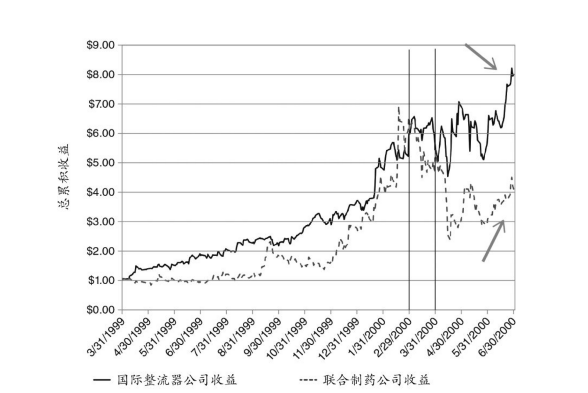
## 高质量动量技巧

1、寻找依靠`价格缓慢增长`实现的高动量；

2、`避免大波动`造成的高动量。

## 技巧说明

价格稳定缓慢增长带来的高动量在样本外更有可能持续走高，而依靠大波动造成的高动量则在样本外难有作为。这两点其实与行为金融学中的两个认知偏差有关：

**`偏差一：Limited Attention `**

+ 人们的认知资源是有限的。在任何给定的时刻，我们的大脑都偏好于处理那些最显著、最重要的信息，而忽略那些不显著、经济效应微弱的因素。


+ Da et al. (2014) 提出了一个假说：一系列频繁但微小的变化对于人的吸引力远不如少数却显著的变化；因此投资者对连续信息造成的股价变化反应不足。

 
+ 提出信息离散性（information discreteness，ID）；并猜想ID低（说明信息连续性强）的动量才是高质量动量，而ID高（信息离散性高）的动量是低质量动量，ID的计算方法如下：


+ `ID=sign(过去一段时间的收益率)×(这段时间内下跌交易日%-这段时间内上涨收益日%)`



+  Da et al.(2014)通过实证说明ID是一个优秀的选股因子（越低好），且它能获得Fama-French三因子无法解释的超额收益。


+  与传统动量相比，通过ID因子筛选找到的高质量动量能够获得更高的超额收益，且该收益在样本外的持续性更强。超额收益的高持续性有助于降低调仓频率、减少换手率、节约交易成本。


**`偏差二：高估值极端事件发生的概率`**

+ 某些股票的收益率分布是右偏的，这些股票称为“lottery-like” 股票。 


+ 行为金融学中的前景理论指出，人们对于极小概率事件发生的主观感受存在认知偏差，会高估它们发生的概率。


+ 对于小概率事件发生可能性的高估导致投资者会过度追逐具有正偏度分布的股票，造成它们的高动量。


+ Bali et al. (2011) 使用一个称作MAX的代理指标研究了这个问题。MAX是过去1个月内日收益率的最大值（美股不设涨跌停板限制，因此更能反映人们对lottery-like股票追逐的疯狂程度）。


+ 使用 MAX将股票分成10组，MAX值最高的那一组为lottery-like 股票，而MAX值最低的那一组称为“无聊”股票。数据显示，`“无聊”股票能显著跑赢lottery-like股票`。

## 适合A股的改进指标

1、对于信息离散性，Da et al.(2014)给出的 ID 作用不大。考虑到目标是为了挑选平时投资者关注度低的股票，我们选择`60个交易日内日换手率的标准差`作为ID的代理指标，其越低越好；

2、选用MAX作为lottery -like股票的代理指标，即`过去20个交易日的日收益率最大值`，它也是越低越好。

## 策略思想
   
1、回测期：2010年1月1日至2020年12月31日；  

2、调仓日：按月调仓，每月末按收盘价买卖股票；  

3、股票池：中证500成分股；剔除ST股票；剔除由于停牌等原因而无法买卖的股票；  

4、交易模型：

+ 采用`等权重法`进行因子打分，将基础版的动量因子Momentum、改进指标ID、改进指标MAX的排名进行加权求平均，得到的平均值即为`综合因子得分SCORE`；


+ 每月末更新动量指标并重新对股票排名，新股理想仓位为1%，等权配置；


+ 将中证500成分股按`综合因子排名`分为5组，综合因子值越大越好，按由小到大排名，组别越大的组合越好，即G5组优于G1组；

## 策略实现
### 构建改进指标ID、MAX
对于MAX指标（**过去20个交易日的日收益率最大值**），对于ID指标（**60个交易日内日换手率的标准差**）需要分别提取各调仓日，各股票的过去60个交易日内的日换手率，并计算其标准差。



In [11]:
class improve_momentum_factor(Factor):

    '''改进动量'''

    import warnings
    warnings.filterwarnings("ignore")

    name = 'improve_momentum_factor'
    max_window = 62
    dependencies = ['close', 'turnover_ratio']

    def calc(self, data) -> pd.Series:

        close_df = data['close']

        # 不包含watch日当日
        pct_df = close_df.pct_change().iloc[1:-1]  # 首日得到的是缺失值，需将其删除
        turnover = data['turnover_ratio'].iloc[1:-1]

        ID = turnover.std()  # 60个交易日内日换手率的标准差
        MAX = pct_df.iloc[-20:].max()  # 过去20个交易日的日收益率最大值

        std_df = pct_df.std()
        ret = close_df.iloc[-1] / close_df.iloc[0] - 1  # r_60
        momentum = ret - 3000 * std_df ** 2  # 传统动量因子

        # 将MAX和ID因子按降序排名，排名越大越好
        rank_data1 = pd.concat((MAX, ID), axis=1).rank(ascending=False)
        # 将动量因子升序排名，排名越大越好
        rank_data2 = momentum.rank(ascending=True)

        rank_data = pd.concat((rank_data1, rank_data2), axis=1)
        rank_data = pd.concat([rank_data1, rank_data2], axis=1)

        # 等权重计算因子得分形成综合因子,因子值越大越好
        return rank_data.mean(axis=1)

In [12]:
start = '2010-01-01'
end = '2020-12-31'
last_date = '2021-01-27'

# 大约8:08min
momentum_df2 = prepare_data('000905.XSHG',start,end,last_date,improve_momentum_factor)

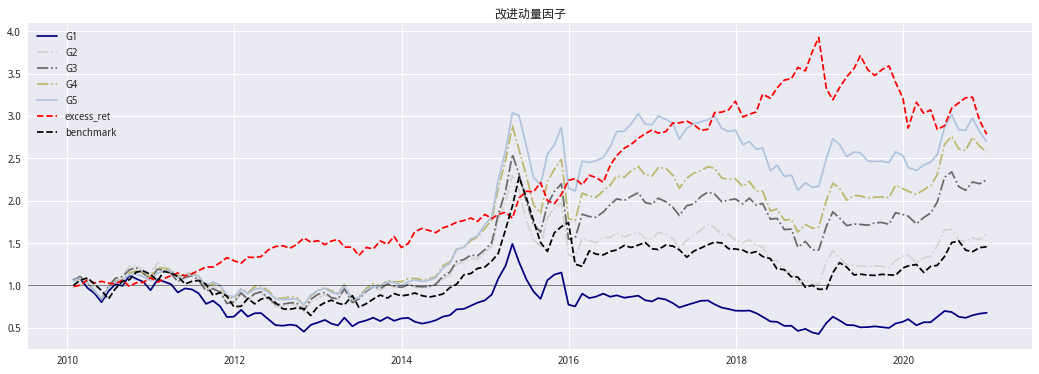

In [23]:
group_df2 = get_group(momentum_df2, 'improve_momentum_factor')
returns2 = get_algorithm_return(group_df2)

benchmark = get_price('000905.XSHG', start, end, fields='close')
benchmark = benchmark.reindex(returns2.index)
benchmark = benchmark['close'].pct_change().fillna(0)
returns2['benchmark'] = benchmark

returns2['excess_ret'] = returns2['G5'] - returns2['G1']
cum_df2 = np.exp(np.log1p(returns2).cumsum())

plot_nav(cum_df2, '改进动量因子')

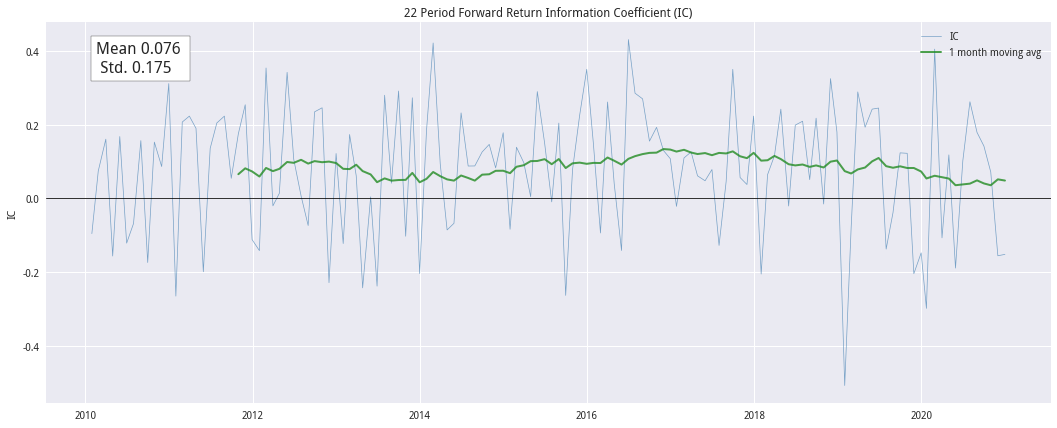

In [14]:
# 转为alphalens规定的格式
al_factor2 = momentum_df2.rename(
    columns={'improve_momentum_factor': 'factor', 'next_ret': 22})

al_factor2 = al_factor2.dropna() # 缺失值较小，这里直接丢弃缺失值 
ic = perf.factor_information_coefficient(al_factor2)
plotting.plot_ic_ts(ic);

各组收益表现与前面的净值曲线结果相对应。无论是从收益角度来看，还是从风险角度来看，G5的表现都是最好的，不仅能取得较高收益，而且风险也最小，收益最稳定，G5的sharpe也是最优的，仍能在承担风险的同时能带来最高的收益。

In [15]:
(Strategy_performance(returns2).style.format('{:.2%}')
                                     .set_caption('动量因子')
                                     .highlight_max(axis=1, color='#d65f5f')
                                     .highlight_min(axis=1, color='#5fba7d'))

,G1,G2,G3,G4,G5,benchmark,excess_ret
年化收益率,-3.51%,4.42%,7.63%,8.98%,9.44%,3.47%,9.75%
波动率,31.97%,28.62%,27.72%,26.08%,24.55%,26.32%,15.42%
夏普,4.72%,29.45%,40.44%,46.13%,49.05%,26.17%,68.31%
最大回撤,-71.43%,-56.15%,-44.38%,-43.54%,-34.11%,-58.18%,-29.11%
IR,-3.86%,1.20%,3.46%,4.31%,4.58%,nan%,3.74%
Alpha,1.02%,7.70%,10.42%,11.09%,10.85%,nan%,9.84%


# 结合对国内市场的观察修正动量因子

长期来看,每天有2%的股票触涨停板,其中当天开板和次日开板的各占34.8%,53.8%,能够连扳的涨停占比比多,每日跌停股票占比1.6%,其中当天开板的达到45.6%,涨跌停的股票占比和持续时间存在显著非对称性。

`磁吸效应`导致接近涨停股票的非理性上涨、解决跌停的股票非理性下跌,而`关注度效应`致使涨跌停股票都被高估,因此涨停的股票后期大概率有**负向**异常收益,而跌停的股票取决于磁吸效应和关注度效应的相对强弱。

由此我们提出与上述改进动量因子不同的处理方法:**计算动量因子时通过剔除触及涨停交易日的收益率,从而使反转效应不在显著**

In [38]:
class delh_momentum(Factor):

    '''改进动量:momentum过滤触及涨停价股票'''

    import warnings
    warnings.filterwarnings("ignore")

    name = 'delh_momentum'
    max_window = 62
    dependencies = ['close', 'turnover_ratio']

    def calc(self, data) -> pd.Series:

        close_df = data['close']
        stocks = close_df.columns.tolist()
        start = close_df.index.min()
        end = close_df.index.max()
     
        # 不包含watch日当日
        pct_df = close_df.pct_change().iloc[1:-1]  # 首日得到的是缺失值，需将其删除
        turnover = data['turnover_ratio'].iloc[1:-1]

        
        ID = turnover.std()  # 60个交易日内日换手率的标准差
        MAX = pct_df.iloc[-20:].max()  # 过去20个交易日的日收益率最大值
        
        # 传统动量因子
        ret = np.log(close_df / close_df.shift(1))
        cond = ~self.touch_limit_h(stocks,start,end) # 未触及涨停的
        std_df = pct_df.std()
        
        ret = (ret * cond).iloc[1:-1].sum()  # r_60
        momentum = ret - 3000 * std_df ** 2  # 传统动量因子

        # 将MAX和ID因子按降序排名，排名越大越好
        rank_data1 = pd.concat((MAX, ID), axis=1).rank(ascending=False)
        # 将动量因子升序排名，排名越大越好
        rank_data2 = momentum.rank(ascending=True)

        rank_data = pd.concat((rank_data1, rank_data2), axis=1)
        rank_data = pd.concat([rank_data1, rank_data2], axis=1)

        # 等权重计算因子得分形成综合因子,因子值越大越好
        return rank_data.mean(axis=1)
    
    @staticmethod
    def touch_limit_h(stocks:list,start:str,end:str)->pd.DataFrame:

        '''当日触及涨停价格'''

        price = get_price(stocks,start_date=start,end_date=end,fields=['high','high_limit'],panel=False)
        pivot_df = price.pivot(index='time',columns='code')

        return pivot_df['high'] >= pivot_df['high_limit']

In [39]:
start = '2010-01-01'
end = '2020-12-31'
last_date = '2021-01-27'

# 大约8:52min
momentum_df3 = prepare_data('000905.XSHG',start,end,last_date,delh_momentum)

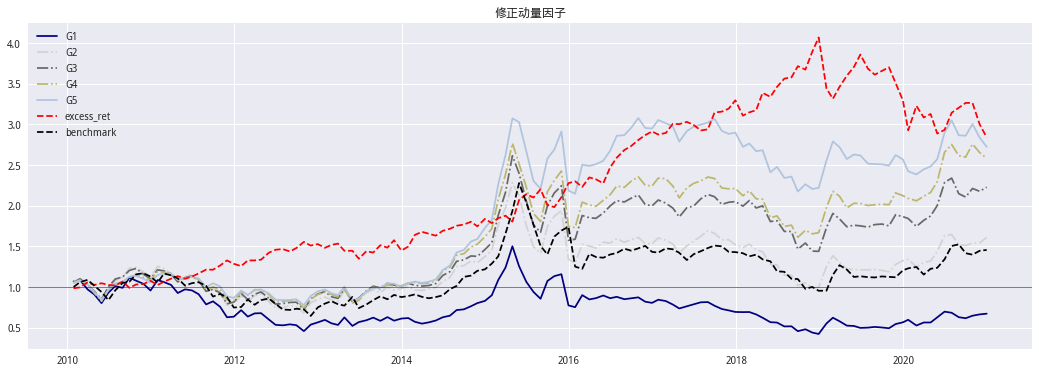

In [40]:
group_df3 = get_group(momentum_df3, 'delh_momentum')
returns3 = get_algorithm_return(group_df3)

benchmark = get_price('000905.XSHG', start, end, fields='close')
benchmark = benchmark.reindex(returns3.index)
benchmark = benchmark['close'].pct_change().fillna(0)
returns3['benchmark'] = benchmark

returns3['excess_ret'] = returns3['G5'] - returns3['G1']
cum_df3 = np.exp(np.log1p(returns3).cumsum())

plot_nav(cum_df3, '修正动量因子')

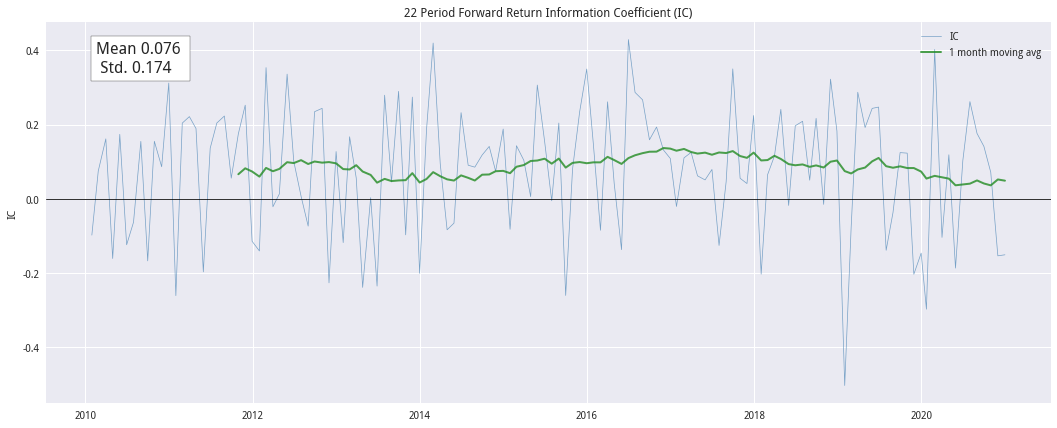

In [41]:
# 转为alphalens规定的格式
al_factor3 = momentum_df3.rename(
    columns={'delh_momentum': 'factor', 'next_ret': 22})

al_factor3 = al_factor3.dropna() # 缺失值较小，这里直接丢弃缺失值 
ic = perf.factor_information_coefficient(al_factor3)
plotting.plot_ic_ts(ic);

In [42]:
(Strategy_performance(returns3).style.format('{:.2%}')
                                     .set_caption('动量因子')
                                     .highlight_max(axis=1, color='#d65f5f')
                                     .highlight_min(axis=1, color='#5fba7d'))

,G1,G2,G3,G4,G5,benchmark,excess_ret
年化收益率,-3.56%,4.42%,7.55%,9.01%,9.54%,3.47%,9.95%
波动率,31.83%,28.90%,27.64%,26.03%,24.59%,26.32%,15.43%
夏普,4.46%,29.41%,40.21%,46.28%,49.36%,26.17%,69.47%
最大回撤,-71.91%,-56.74%,-44.97%,-41.79%,-33.59%,-58.18%,-30.22%
IR,-3.92%,1.26%,3.39%,4.33%,4.65%,nan%,3.96%
Alpha,0.99%,7.70%,10.30%,11.12%,10.96%,nan%,9.97%


# 基础版策略与升级版策略对比分析

## 策略收益对比分析

通过将两个策略的回测净值放于同一副图中，发现基础版策略的表现优于基准的表现，而升级版策略的表现优于基础版策略的表现。

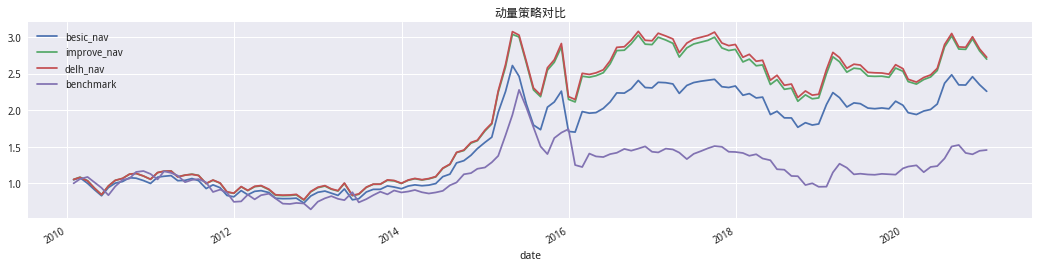

In [43]:
competition_cum = pd.concat(
    (cum_df1['G5'], cum_df2['G5'],cum_df3[['G5', 'benchmark']]), axis=1)
competition_cum.columns = ['besic_nav', 'improve_nav','delh_nav', 'benchmark']

competition_cum.plot(figsize=(18, 4), title='动量策略对比')

无论是从收益角度来看，还是从风险角度来看，升级版策略的表现都是最好的，不仅能取得较高收益，而且风险也最小，收益最稳定，升级版的sharpe也是最优的，仍能在承担风险的同时能带来最高的收益；同理基础版策略要优于基准；

In [27]:
competition_returns = pd.concat(
    (returns1['G5'], returns2['G5'],returns3[['G5', 'benchmark']]), axis=1)
competition_returns.columns = ['besic_nav', 'improve_nav','delh_nav', 'benchmark']
performance_df = Strategy_performance(competition_returns)

(performance_df.style.format('{:.2%}')
 .set_caption('动量因子对比')
 .highlight_max(axis=1, color='#d65f5f')
 .highlight_min(axis=1, color='#5fba7d'))

,besic_nav,improve_nav,delh_nav,benchmark
年化收益率,7.69%,9.44%,9.54%,3.47%
波动率,23.82%,24.55%,24.59%,26.32%
夏普,43.05%,49.05%,49.36%,26.17%
最大回撤,-34.88%,-34.11%,-33.59%,-58.18%
IR,2.98%,4.58%,4.65%,nan%
Alpha,9.26%,10.85%,10.96%,nan%


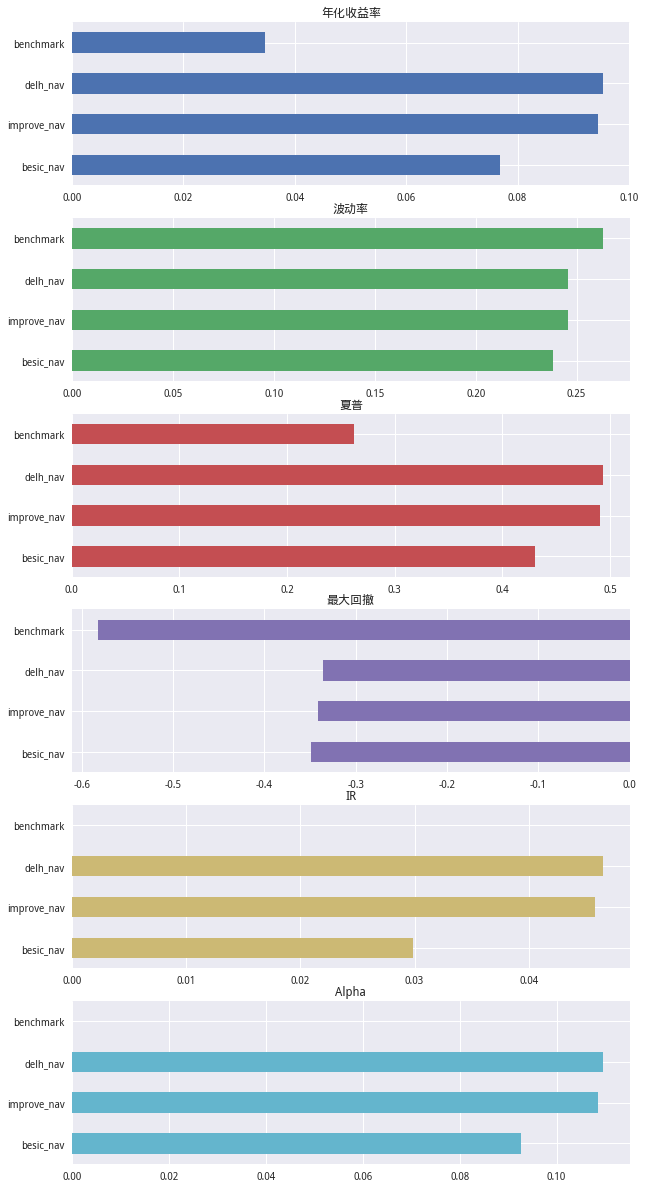

In [28]:
performance_df.T.plot(kind='barh', subplots=True,
                      figsize=(10, 21), sharex=False, legend=[]);

# 动量策略并不适合所有人

## 无法继续打败基准
在2017年之前，无论是正收益还是负收益，升级版动量策略的表现都是优于基准的；但从2017年开始，再加上2018年，升级版动量策略的表现变得不如基准的表现好，升级版动量策略无法继续打败基准。

In [29]:
def get_return_everyyear(returns: pd.DataFrame) -> pd.DataFrame:
    
    annual_ret = returns.groupby(pd.Grouper(level='date', freq='Y')).apply(
        lambda x: ep.annual_return(x, period='monthly'))
    
    annual_ret.index = annual_ret.index.year
    
    return annual_ret

In [30]:
yearly_df = get_return_everyyear(
    competition_returns[['delh_nav', 'benchmark']])

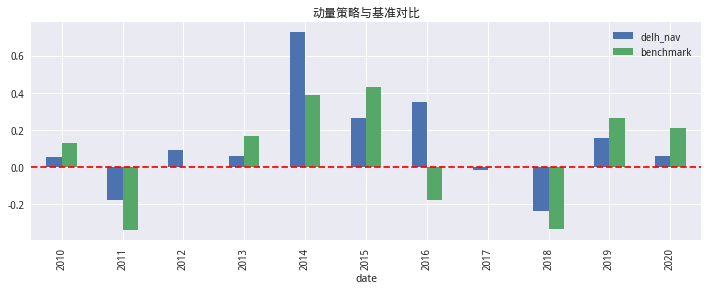

In [31]:
yearly_df.plot(kind='bar', figsize=(12, 4), title='动量策略与基准对比')
plt.axhline(0, color='r', ls='--');

## 动量策略背后的业务支撑



1、`普通交易者的认知偏差`造成了市场的定价错误；

2、`高昂的套利成本`使得聪明投资者无法充分消除定价错误。

## 错误定价成因（Barberis et al. 1998 模型）

1、**好的盈利消息连续出现会引起投资者的过度反应。**投资者产生`选择性偏差`，过度看中最近发生的这些连续的利好消息、并把这种预期外推到对公司未来股价的预测上；一旦未来的盈利没有达到预期，就会引起他们的恐慌，造成股价的下跌，这是`成长投资`的特点。

2、**当好的盈利消息非连续出现时，投资者会对它们反应不足。**这时投资者会出现`保守主义偏差`。他们会对这个利好持怀疑态度、不情愿更新他们对于该公司基本面的认知，导致无法有效的对股价做出调整。随着时间的推移，当该公司又逐渐出现新的盈利利好时，其股价才会慢慢对其新的基本面反映到位，这就是`动量投资`。

## 有限套利

### 高昂的套利成本使得聪明投资者无法充分消除定价错误。

**`有限套利（Limits to Arbitrage）:`**
假设A和B两地都卖苹果，A地价格5块一斤，B地价格10块一斤；苹果B地存在错误定价。面对这个情况，理论上的做法是从A地买苹果然后拿到B地去卖，赚取 5 块钱一斤的差价。这么做的人多了，就会造成B地价格下降，最终消除定价错误。  

在现实中，套利者必须考虑各种成本，比如 A 和 B 两地的运输成本，对苹果的储藏成本，两地出租商铺的不同开销以及税收区别；此外，还要有苹果价格下跌的风险 —— 在把苹果从 A 运到 B 的过程中，苹果的价格可能下跌，甚至跌破套利者的成本。这些成本使得聪明人不敢毫无顾虑的套利。

## 聪明投资者的顾虑

1、定价错误在短期内不一定会被修正，可能还会进一步放大。  

2、对于聪明交易者来说，交易动量策略最大的`套利风险是由于动量策略在短期相对于基准指数的弱势表现而造成的职业风险`。  

3、市场上的资金大多都是`short-sighted performance chasers`，仅根据`短期`相对于基准的表现来评估基金经理的业绩。这让基金经理于进退两难的局面。一方面，基金经理希望利用定价错误交易动量策略，因为长期来看这么做的期望收益能够战胜基准；但另一方面，他们这样做的前提是短期内不会威胁到他们手中的资金 —— 投资者不会因为业绩短期跑输基准而赎回资金。

## 对动量策略的正确认识

1、动量策略在短期可能会跑输市场，因此并不适合所有人（资金）；

2、长期来看，动量策略会战胜市场。对于那些过程驱动、以长期盈利为目标（而忽视短期波动）、能够严格遵守交易纪律的投资者来说，动量策略值得配置；  

3、大量跨市场实证指出，`动量和价值是两个长期来看负相关的因子`。因此，`动量策略的最好归宿是和价值策略配合在一起`，提高投资组合的风险收益特征。

# 总结

1、两处改进让我们获得了**高质量动量因子**；**提升策略的收益风险比**。

2、以上实证仅是为了给大家介绍改进的思路。具体是否使用上述代理指标及参数需要结合不同的动量选股策略来考量。

3、`路径很重要！`